<a href="https://colab.research.google.com/github/baroneleonardo/NO2-Virtual-Sensor/blob/main/KFOLD_ML_NN_bea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import kerastuner
from kerastuner.tuners import RandomSearch


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
data = pd.read_csv("data_dausare.csv")
data = data.set_index('Datetime')
data.describe()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.707856,939.029205,835.370973,113.075515,1022.780725,18.316054,49.232360,1.025530
std,217.084571,266.829000,256.815106,48.359250,398.480897,8.832888,17.316389,0.403813
min,647.250000,383.250000,322.000000,2.000000,221.000000,-1.900000,9.175000,0.184679
25%,936.750000,734.375000,657.875000,78.000000,731.375000,11.787500,35.812500,0.736769
50%,1063.000000,909.000000,805.500000,109.000000,963.250000,17.750000,49.550000,0.995395
75%,1231.250000,1116.250000,969.250000,142.000000,1273.375000,24.400000,62.500001,1.313701
max,2039.750000,2214.000000,2682.750000,339.700000,2522.750000,44.600000,88.725000,2.231036


In [139]:
data = data.dropna(subset=["NO2(GT)"])
data = data.dropna(subset=["T"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7393 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7393 non-null   float64
 1   PT08.S2(NMHC)  7393 non-null   float64
 2   PT08.S3(NOx)   7393 non-null   float64
 3   NO2(GT)        7393 non-null   float64
 4   PT08.S5(O3)    7393 non-null   float64
 5   T              7393 non-null   float64
 6   RH             7393 non-null   float64
 7   AH             7393 non-null   float64
dtypes: float64(8)
memory usage: 519.8+ KB


In [140]:
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU
print(tf.__version__)

2.12.0


In [141]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=seed, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True)

In [144]:
input_shape = X_train.shape[1:]
input_shape

(7,)

#NN

In [142]:
from sklearn.preprocessing import MinMaxScaler


target = pd.DataFrame(data['NO2(GT)'])
X = data.drop(['NO2(GT)'], axis=1)
print('NO2 data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

#do the same for y

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


y_scaled.describe()   
x_scaled.describe()

NO2 data_normset shape (7393, 7)
Target shape (7393, 1)


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S5(O3),T,RH,AH
count,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000
mean,0.333748,0.309864,0.212836,0.358246,0.427159,0.497782,0.405859
std,0.156757,0.144993,0.108836,0.176336,0.193585,0.219921,0.202238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.217056,0.199918,0.138304,0.228956,0.283333,0.326210,0.257746
50%,0.309156,0.295917,0.198877,0.334419,0.408602,0.500629,0.390793
75%,0.430162,0.406527,0.267923,0.471924,0.558065,0.666248,0.544303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
def build_model():
    model=keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    #No activation is used in the last layer as this is regression
    optimizer= tf.keras.optimizers.Adam(0.001)
    
    model.compile(loss='mse',
                 optimizer= optimizer,
                 metrics= ['mae', 'mse'])
    return model

In [146]:
model= build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1024      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [147]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    verbose=1, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= model.evaluate(X_test, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) 

Epoch 1/200
158/158 [==============================] - 2s 4ms/step - loss: 0.0097 - mae: 0.0704 - mse: 0.0097 - val_loss: 0.0056 - val_mae: 0.0567 - val_mse: 0.0056
Epoch 2/200
158/158 [==============================] - 1s 3ms/step - loss: 0.0047 - mae: 0.0517 - mse: 0.0047 - val_loss: 0.0048 - val_mae: 0.0507 - val_mse: 0.0048
Epoch 3/200
158/158 [==============================] - 1s 3ms/step - loss: 0.0042 - mae: 0.0489 - mse: 0.0042 - val_loss: 0.0045 - val_mae: 0.0495 - val_mse: 0.0045
Epoch 4/200
158/158 [==============================] - 1s 3ms/step - loss: 0.0040 - mae: 0.0475 - mse: 0.0040 - val_loss: 0.0047 - val_mae: 0.0499 - val_mse: 0.0047
Epoch 5/200
158/158 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0464 - mse: 0.0039 - val_loss: 0.0049 - val_mae: 0.0527 - val_mse: 0.0049
Epoch 6/200
158/158 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0467 - mse: 0.0039 - val_loss: 0.0044 - val_mae: 0.0466 - val_mse: 0.0044
Epoch 7/20

In [148]:
y_pred=model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 1ms/step
MSE 0.0030604623114039516
R2 0.8476709245024239


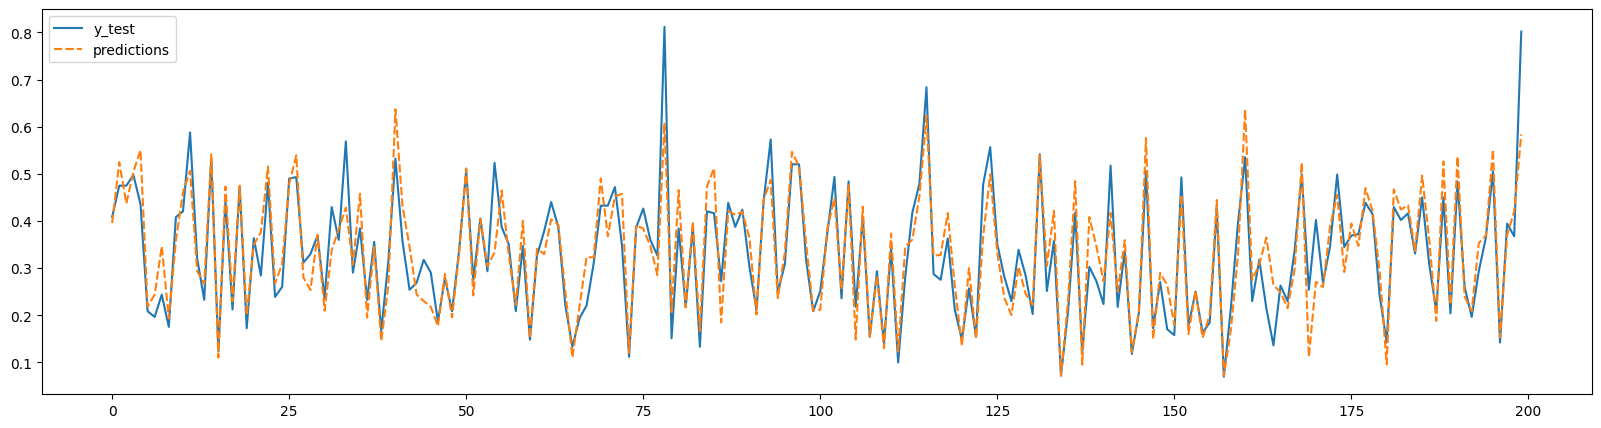

In [149]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:200, :])
plt.show()

#Tuning 

In [150]:

def build(hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=32, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model


In [151]:
MAX_TRIALS = 20
tuner= RandomSearch(build,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               #executions_per_trial= EXECUTION_PER_TRIAL,
               directory= 'random_search',
               project_name='houseprices',
               overwrite=True)

In [152]:
print('searching for the best params!')

tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_val, y_val),
             verbose=0,
             callbacks= []
            )

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


In [153]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')}  

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 64 
third layer is 32  

and the optimal learning rate for the optimizer
is 0.0032285872305509375.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
tuned_model = tuner.hypermodel.build(best_hps)

# Check result using best model
history_tuned= tuned_model.fit(X_train, y_train, 
          epochs = 200, 
          validation_data = (X_val, y_val),
          verbose=0,
          callbacks= early_stopping_cb)


In [155]:
y_pred=tuned_model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 2ms/step
MSE 0.0033882477757909953
R2 0.8313559852314624


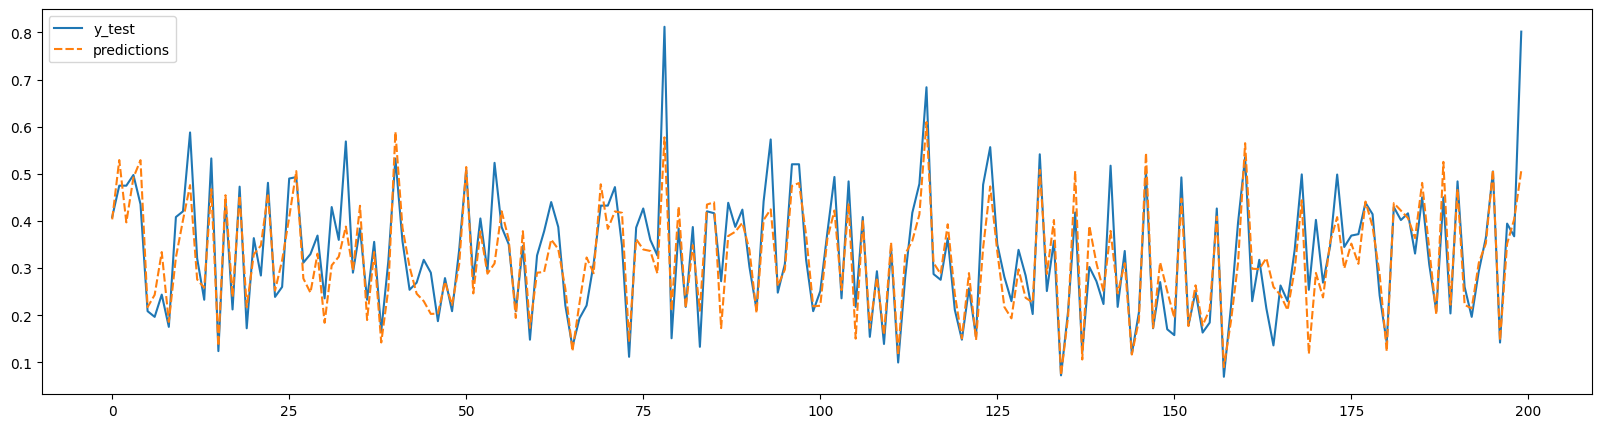

In [156]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:200, :])
plt.show()

###K-FOLD on Tuned Model

In [157]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow.keras.metrics as tfk

# Definisci il numero di fold
num_folds = 5
epochs=200
batch_size=32
# Crea gli array vuoti per memorizzare i risultati di ogni fold
mse_scores = []
mae_scores = []
rmse_scores = []

# Crea gli array di dati e target
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=seed, shuffle=True)
data_k = np.concatenate((X_train, y_train), axis=1)

# Inizializza l'oggetto KFold
kf = KFold(n_splits=num_folds, shuffle=True)

# Itera su ogni fold
for train_index, val_index in kf.split(data_k):
    # Divide i dati in training set e validation set
    train_data, val_data = data_k[train_index], data_k[val_index]
    
    # Separa le features e i target
    X_train_fold, y_train_fold = train_data[:, :-1], train_data[:, -1]
    X_val_fold, y_val_fold = val_data[:, :-1], val_data[:, -1]
    
    # Costruisci il modello
    ffnn = model
    
    # Addestramento del modello
    history = ffnn.fit(
        X_train_fold, y_train_fold,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=early_stopping_cb,
        verbose=0
    )
    
    # Calcola le metriche di valutazione sul fold corrente
    mse, mae, rmse = ffnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

# Calcola la media delle metriche di valutazione su tutti i fold
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)

# Stampa i risultati
print("Mean Squared Error (MSE):", avg_mse)
print("Mean Absolute Error (MAE):", avg_mae)
print("Root Mean Squared Error (RMSE):", avg_rmse)


Epoch 47: early stopping
Epoch 26: early stopping
Epoch 24: early stopping
Epoch 22: early stopping
Epoch 21: early stopping
Mean Squared Error (MSE): 0.0024468956980854273
Mean Absolute Error (MAE): 0.03584680780768394
Root Mean Squared Error (RMSE): 0.0024468956980854273


In [158]:
y_pred=ffnn.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 2ms/step
MSE 0.002861979390447215
R2 0.857550059343829


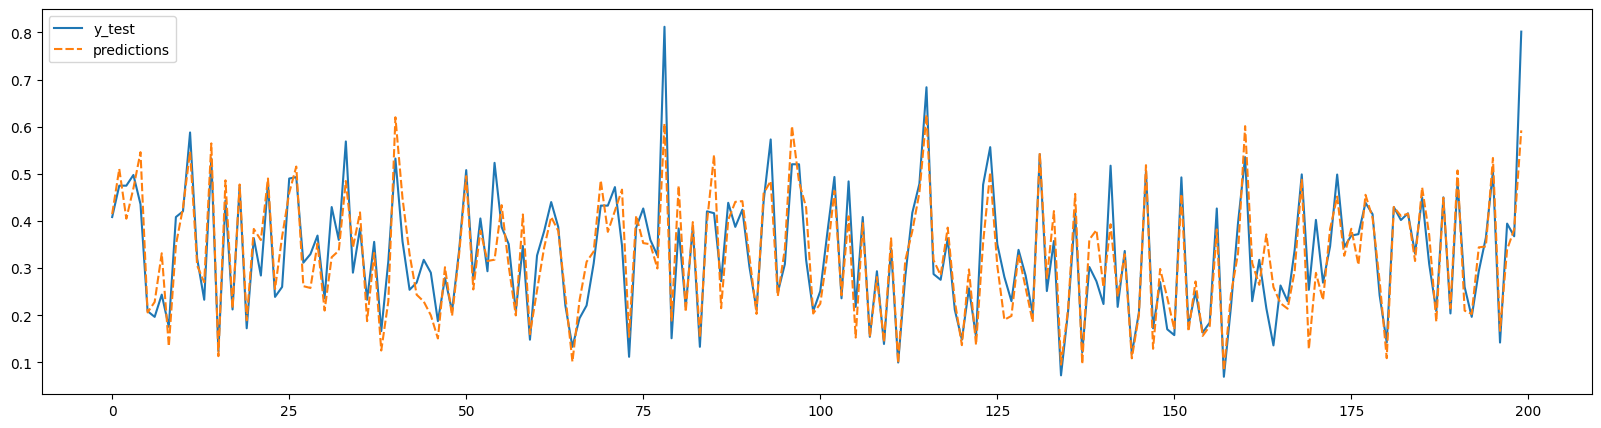

In [159]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:200, :])
plt.show()